*****
# Intel® Scalable Dataframe Compiler
*****

### A compiler-based framework for big data in Python  
Intel® Scalable Dataframe Compiler (Intel® SDC) and Numba are strategic technologies for scaling up and out performance critical HPC and Data Analytics workflows

*****

## Installing

*Installing Binary Packages (conda)*  
`conda install -c intel sdc`

SDC advances numba in two dimensions:

1. Support for pandas dataframes and operations  
2. Scaling out to a cluster using MPI

## Machine Learning Problem Statement

The notebook below has been made to demonstrate sdc and daal4py in a data science context. It applies a Cycling Dataset from a social fitness network, and attempts to create a linear regression model from the 5 features collected for telemetry to predict the user's Power output in the absence of a power meter.  

In [1]:
import sdc
import numba

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load and Prepare the data

In [18]:
@sdc.jit
# @numba.jit(nopython=True, parallel='True')
def read_from_csv():
    filename = 'data/cycling_dataset_1.csv'
    # Currrently we need to provide column names and their types
    names = ['altitude', 'cadence', 'distance', 'hr', 'latitude', 'longitude', 'power', 'speed', 'time']
    dtypes = {
        'altitude': np.float64,
        'cadence': np.float64,
        'distance': np.float64,
        'hr': np.float64,
        'latitude': np.float64,
        'longitude': np.float64,
        'power': np.float64,
        'speed': np.float64,
        'time': str
    }
    df = pd.read_csv(filename, names=names, dtype=dtypes)
    return df

In [19]:
df = read_from_csv()
df.head()

,altitude,cadence,distance,hr,latitude,longitude,power,speed,time
0,185.800003,51.0,3.46,81.0,30.313309,-97.732711,45.0,3.459,2016-10-20 22:01:26
1,185.800003,68.0,7.17,82.0,30.313277,-97.732715,0.0,3.710,2016-10-20 22:01:27
2,186.399994,38.0,11.04,82.0,30.313243,-97.732717,42.0,3.874,2016-10-20 22:01:28
3,186.800003,38.0,15.18,83.0,30.313212,-97.732720,5.0,4.135,2016-10-20 22:01:29
4,186.600006,38.0,19.43,83.0,30.313172,-97.732723,1.0,4.250,2016-10-20 22:01:30


## Performance of dataset loading from csv

Intel(R) Xeon(R) Platinum 8280 CPU @ 2.70GHz  
Core(s) per socket: 28  
RAM: 256GB

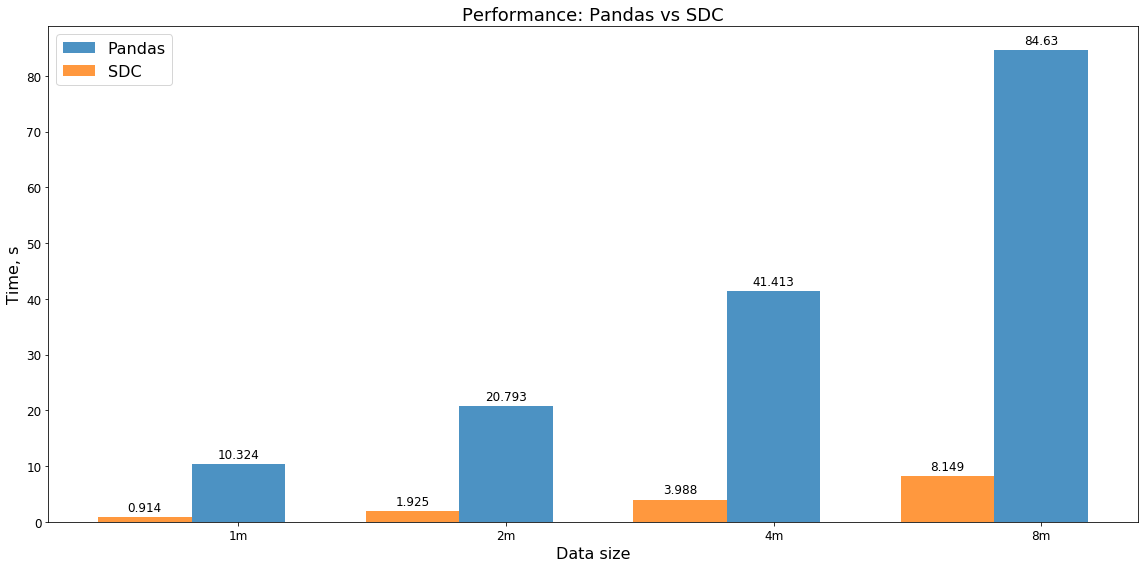

In [2]:
from plotting import Plotter

pl = Plotter('read_csv')
pl.plot_performance()

**Try it with MPI: run on 4 processes**  
`!mpirun -n 4 python ./runme.py`

## Performance of dataframe methods

In [9]:
@sdc.jit
def data_statistics(df):
    df_column = df['distance']
    data_sum = df_column.sum()
    data_max = df_column.max()
    data_mean = df_column.mean()
    data_min = df_column.min()
    data_prod = df_column.prod()

    return data_sum, data_max, data_mean, data_min, data_prod

In [11]:
data_sum, data_max, data_mean, data_min, data_prod = data_statistics(df)
print(data_max)
print(data_mean)

6186.3701171875
3094.0427492866515


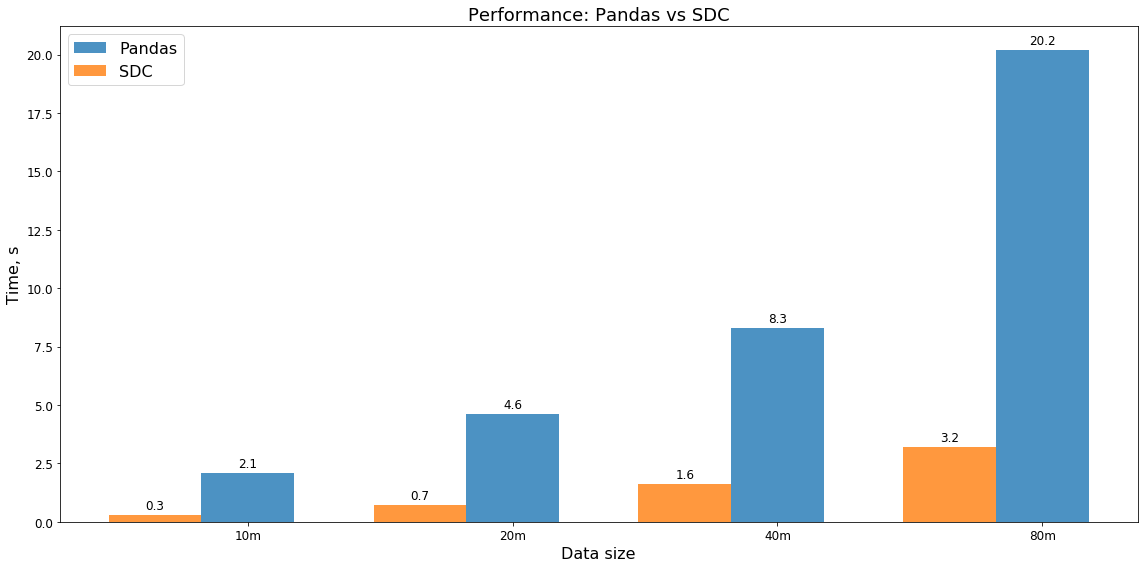

In [2]:
from plotting import Plotter

pl = Plotter('statistics')
pl.plot_performance()

## SDC scalability

In [13]:
def data_sum_series(s1, s2):
    start = time.time()
    result = (s1+s2).sum()
    end = time.time() - start
    return result, end

In [16]:
# SDC scalability: multithreading
s1 = pd.Series(np.repeat(df.altitude.values, 500))
s2 = pd.Series(np.repeat(df.cadence.values, 500))

sdc_no_parallel = sdc.jit(parallel=False)(data_sum_series)
sdc_parallel = sdc.jit(parallel=True)(data_sum_series)

_, t_py = data_sum_series(s1, s2)
_, t_np = sdc_no_parallel(s1, s2)
_, t_p = sdc_parallel(s1, s2)

print("TIME Python: ", t_py)
print("TIME SDC No Parallel: ", t_np)
print("TIME SDC Parallel: ", t_p)

TIME Python:  29.691943883895874
TIME SDC No Parallel:  14.527932917146245
TIME SDC Parallel:  3.1467556294228416


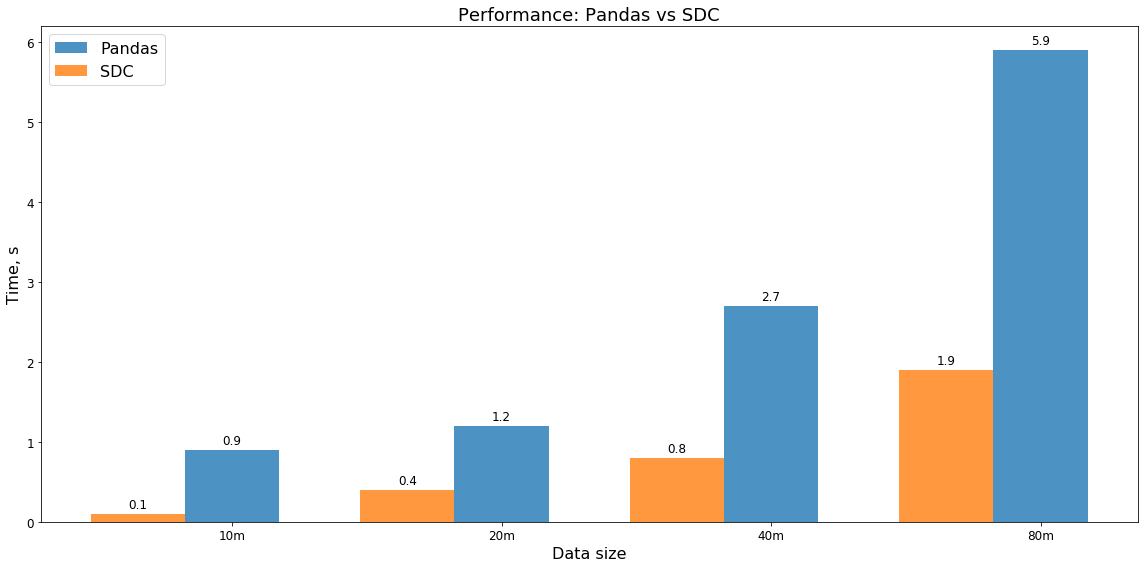

In [3]:
from plotting import Plotter

pl = Plotter('sum')
pl.plot_performance()

## Split the data

In [7]:
def data_split(df):
    start = time.time()
    # Remove entries where power==0
    train = df.drop('time', axis=1)
    train = train[df.power!=0]
    # Reduce the dataset, create X.  We drop the target, and other non-essential features
    reduced_train = train.drop(['power','latitude','longitude'], axis=1)
    # Get the target, create Y as an 2d array of float64
    target = train.power.values.reshape(len(train),1).astype(np.float64)
    end = time.time() - start
    
    return reduced_train, target, end

In [8]:
sdc_split = sdc.jit(data_split)
train, target, t = data_split(df)
sdc_train, sdc_target, sdc_t = sdc_split(df)

print("TIME python: ", t)
print("TIME SDC: ", sdc_t)

TIME python:  0.3322134017944336
TIME SDC:  0.20170818027690984


## Train the model

After the data was previously processed it can be passed to the ML model input.  
The following code trains a model to predict the power output.

In [44]:
import daal4py as d4p

In [45]:
# Create a linear regression algorithm object
d4p_lm = d4p.linear_regression_training(interceptFlag=True)
# Train the model
lm_trained = d4p_lm.compute(sdc_train.values, sdc_target)

In [46]:
print("Model has this number of features: ", lm_trained.model.NumberOfFeatures)

Model has this number of features:  5


## Predict

In [47]:
def predict(model):
    test_set = pd.read_parquet('cycling_test_dataset.pq')
    test_set = test_set[test_set.power!=0]
    subset = test_set.drop(['time','power','latitude','longitude'], axis=1)
    # create our prediction algorithm object
    lm_predictor = d4p.linear_regression_prediction()
    # Now run prediction. The arguments use the independent data and the trained model from above as the parameters.
    result = lm_predictor.compute(subset.values, model)
    
    return result

In [48]:
pred_result = predict(lm_trained.model)

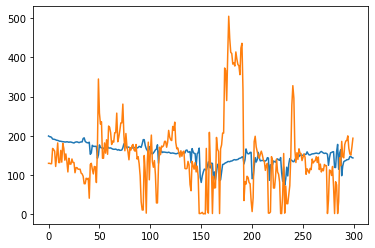

In [49]:
test_set = pd.read_parquet('cycling_test_dataset.pq')
test_set = test_set[test_set.power!=0]
plt.plot(pred_result.prediction[0:300])
plt.plot(test_set.power.values[0:300])
plt.show()